In [8]:
import os
import sys

# Get the current working directory (where your notebook is running)
script_dir = os.getcwd()

# Go one level up
parent_dir = os.path.abspath(os.path.join(script_dir, os.pardir))

# Insert the parent directory into Python path
sys.path.insert(0, parent_dir)

print("Script directory:", script_dir)
print("Parent directory:", parent_dir)

Script directory: c:\Users\yangzhec\OneDrive - KTH\Projects\HYSTORE\PCM_flexibility_mdp\results
Parent directory: c:\Users\yangzhec\OneDrive - KTH\Projects\HYSTORE\PCM_flexibility_mdp


In [12]:
import numpy as np
import pandas as pd
import math
from env.pcm_storage import hp_system

In [ ]:
def solve_rpm_and_eer(Q_cool, dt, T_cond, hp):
    """
    Given:
      Q_cool (kWh)  : Total cooling provided in time dt
      dt (s)        : Duration of the interval in seconds
      T_cond (°C)   : Condenser temperature
      hp            : An object with attributes:
                      hp.Q_intercept, hp.a, hp.b, hp.c, hp.d,
                      hp.EER_intercept, hp.e, hp.f, hp.g, hp.h
    
    Returns:
      (e, EER)
      where e is the electrical energy (kWh) used over dt,
            EER is the dimensionless energy-efficiency ratio.
    """
    # 1) Compute Q_dot_cool (kW)
    Q_dot_cool = Q_cool * 3600.0 / dt  # kW

    # 2) Solve for rpm from the polynomial:
    #    c*rpm^2 + a*rpm + (Q_intercept + b*T_cond + d*T_cond^2 - Q_dot_cool) = 0
    A = hp.c
    B = hp.a
    C = (hp.Q_intercept 
         + hp.b * T_cond 
         + hp.d * (T_cond ** 2) 
         - Q_dot_cool)

    # Handle the case where A is nearly 0 (degenerate quadratic => linear)
    if abs(A) < 1e-12:
        if abs(B) < 1e-12:
            raise ValueError("Both c and a are ~0, cannot solve.")
        rpm_candidate = -C / B
        if rpm_candidate <= 0:
            raise ValueError("No positive RPM solution found in linear case.")
        rpm = rpm_candidate
    else:
        # Solve the quadratic equation for rpm
        disc = B**2 - 4*A*C
        if disc < 0:
            # If the discriminant is negative, then set rpm and EER to 0
            return 0, 0

        sqrt_disc = math.sqrt(disc)
        rpm1 = (-B + sqrt_disc) / (2*A)
        rpm2 = (-B - sqrt_disc) / (2*A)

        # Filter for physically valid (positive) solutions
        candidates = [r for r in (rpm1, rpm2) if r > 0]
        if not candidates:
            raise ValueError("No positive RPM solution found.")
        rpm = candidates[0]
    
    # 3) Compute EER with the solved rpm
    EER = (hp.EER_intercept
           + hp.e * rpm
           + hp.f * T_cond
           + hp.g * (rpm ** 2)
           + hp.h * (T_cond ** 2))
    
    # If EER is zero, avoid division by zero; otherwise compute e.
    if EER == 0:
        e = 0
    else:
        e = Q_cool / EER

    return e, EER

Benchmark_1H

In [11]:
hp_15T = hp_system(dt=900)   # Initialize the HP system

In [21]:
total_df = pd.read_pickle(os.path.join(parent_dir, 'data', 'total_df.pkl'))

baseline_15T = pd.DataFrame()

dt = 900

# Use DataFrame.apply with a lambda that calls solve_rpm_and_eer
baseline_15T[['e', 'EER']] = total_df.apply(
    lambda row: solve_rpm_and_eer(row['load'], dt, row['outdoor_temp'], hp_15T),
    axis=1,
    result_type='expand'
)

baseline_15T.to_pickle('./baseline_15T.pkl')

In [22]:
total_df_hourly = pd.read_pickle(os.path.join(parent_dir, 'data', 'total_df_hourly.pkl'))

baseline_1H = pd.DataFrame()

dt = 3600

# Use DataFrame.apply with a lambda that calls solve_rpm_and_eer
baseline_1H[['e', 'EER']] = total_df_hourly.apply(
    lambda row: solve_rpm_and_eer(row['load'], dt, row['outdoor_temp'], hp_15T),
    axis=1,
    result_type='expand'
)

baseline_15T.to_pickle('./baseline_15T.pkl')

Results analysis

In [2]:
df_results = pd.read_pickle('./results.pkl')
display(df_results)

,rpm,u_hp,Q_pcm,soc,outdoor_temp,e_price,load,u_pcm
0,2073.039358,1.0,5.0,0.000000,20.3000,0.10808,0.000000,1.0
1,2339.550313,0.0,5.0,0.229037,19.8500,0.09000,0.000000,1.0
2,2614.479365,0.0,0.0,0.042397,19.3625,0.07416,0.000000,0.0
3,1947.161495,1.0,0.0,0.828357,19.1250,0.07711,0.000000,0.0
4,1858.467620,0.0,0.0,0.815844,18.9250,0.10808,0.000000,0.0
...,...,...,...,...,...,...,...,...
727,2051.056575,0.0,0.0,0.864894,22.8125,0.10400,0.000000,0.0
728,1655.355659,0.0,0.0,0.170190,23.7750,0.10400,3.381651,0.0
729,1579.616191,0.0,-5.0,0.931102,24.7750,0.10300,30.174844,1.0
730,1286.130119,0.0,-5.0,0.875199,25.6875,0.09900,41.951029,1.0


<Axes: >

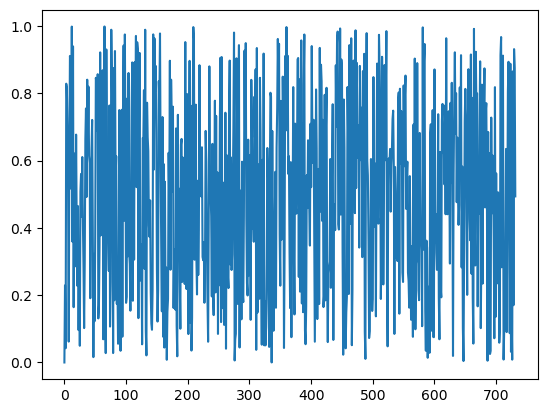

In [3]:
df_results['soc'].plot()